# KoBART Basline Train
- 모듈에서 불러오는 모델 아니고 huggingface에서 불러와서 적용
- 일반적 tokenizer말고 BART에 최적화된 토크나이저 불러옴

https://huggingface.co/hyunwoongko/kobart

## 0. 라이브러리 및 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import torch.optim as optim

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
from transformers import PreTrainedTokenizerFast, BartForConditionalGeneration

tokenizer = PreTrainedTokenizerFast.from_pretrained('hyunwoongko/kobart')
model = BartForConditionalGeneration.from_pretrained("hyunwoongko/kobart")

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


데이터 불러오기

In [27]:
df = pd.read_csv('/content/drive/MyDrive/0000/project_coda/dataset/GKSL3k_original.csv')
df.columns = ['category', 'video_num', 'question_morph', 'question', 'gloss', 'text']
df.head(30)

,category,video_num,question_morph,question,gloss,text
0,KETI-Emergency,NaN,NaN,False,집 불,집에 불이 났어요.
1,KETI-Emergency,NaN,NaN,False,집 도둑 넘어오다,집에 도둑이 들어왔어요.
2,KETI-Emergency,NaN,NaN,False,누가 교통사고,어떤 사람이 교통사고를 당했어요.
3,KETI-Emergency,NaN,NaN,False,먹다 중간 목 실수 삼키다,식사를 하다가 목에 음식이 걸렸어요.
4,KETI-Emergency,NaN,NaN,False,홍수 집 물 채우다,홍수가 나서 집이 물에 잠기고 있어요.
5,KETI-Emergency,NaN,NaN,False,엘리베이터 갑자기 멈추다,엘리베이터가 갑자기 중간에 멈췄어요.
6,KETI-Emergency,NaN,NaN,False,누가 자살 중,어떤 사람이 자살을 시도하고 있어요.
7,KETI-Emergency,NaN,NaN,False,누가 바다 빠지다 헤엄치다,어떤 사람이 바다에 빠졌어요.
8,KETI-Emergency,NaN,NaN,False,바다 가깝다 곳 상어 오다,해안가에 상어가 나타났어요.
9,KETI-Emergency,NaN,NaN,False,바다 가깝다 곳 해파리 오다,해안가에 해파리가 나타났어요.


## 1. 데이터 파악

In [28]:
len(df), len(df.gloss.unique()), len(df.text.unique())

(3052, 2115, 1378)

왜 똑같은 문장이 많지?

In [29]:
for i in df.category.unique():
  print(i, ':', len(df[df.category==i]))

KETI-Emergency : 105
NIA-2020 : 2000
KETI-Airport : 397
KETI-Daily : 550


In [30]:
df[df.category=='NIA-2020'].head(30)

,category,video_num,question_morph,question,gloss,text
105,NIA-2020,1.0,NaN,False,왼쪽,왼쪽입니다.
106,NIA-2020,2.0,X,True,왼쪽,왼쪽이요?
107,NIA-2020,3.0,NaN,False,오른쪽,오른쪽입니다.
108,NIA-2020,4.0,X,True,오른쪽,오른쪽이요?
109,NIA-2020,5.0,NaN,False,여기,이것입니다.
110,NIA-2020,6.0,X,True,여기,이것인가요?
111,NIA-2020,7.0,NaN,False,저기,저것입니다.
112,NIA-2020,8.0,NaN,True,저기,저것인가요?
113,NIA-2020,9.0,NaN,False,운전 천천히,천천히 가주세요.
114,NIA-2020,10.0,NaN,True,운전 천천히,천천히 가드릴까요?


- 문맥에 따라 gloss가 다르게 text로 변환되는 경우가 있어서 똑같은 gloss는 많은 걸로 보임
- text는..?
- 추가로 의문문 유무 파악은 표정에서 따내는 건가

In [31]:
print(len(df[df.question==True]))
df[df.question==True].head(10)

1346


,category,video_num,question_morph,question,gloss,text
106,NIA-2020,2.0,X,True,왼쪽,왼쪽이요?
108,NIA-2020,4.0,X,True,오른쪽,오른쪽이요?
110,NIA-2020,6.0,X,True,여기,이것인가요?
112,NIA-2020,8.0,NaN,True,저기,저것인가요?
114,NIA-2020,10.0,NaN,True,운전 천천히,천천히 가드릴까요?
116,NIA-2020,12.0,NaN,True,가다 빨리,빨리 가드릴까요?
118,NIA-2020,14.0,NaN,True,시간 급하다,많이 급하세요?
120,NIA-2020,16.0,X,True,급하다,급하세요?
122,NIA-2020,18.0,NaN,True,약속 늦다,약속시간에 늦으셨나요?
124,NIA-2020,20.0,X,True,나,저요?


우리는 기록용이니까 일단 의문문은 포함하지 않고 진행


=> 근데 이러면 데이터 절반이 날라감

### 데이터 전처리

In [32]:
df = df[df.question==False]
df = df[['gloss', 'text']]
df

,gloss,text
0,집 불,집에 불이 났어요.
1,집 도둑 넘어오다,집에 도둑이 들어왔어요.
2,누가 교통사고,어떤 사람이 교통사고를 당했어요.
3,먹다 중간 목 실수 삼키다,식사를 하다가 목에 음식이 걸렸어요.
4,홍수 집 물 채우다,홍수가 나서 집이 물에 잠기고 있어요.
...,...,...
3047,도착 시간 저녁 9시 정도,도착시간은 오후 9시가 되겠습니다
3048,아이 지금 5 되다,아이가 다섯 살이 되었다
3049,잘 되다 부탁,잘 되길 바래
3050,미래 의사 원하다,커서 의사가 되고 싶다


In [33]:
df.head(10)

,gloss,text
0,집 불,집에 불이 났어요.
1,집 도둑 넘어오다,집에 도둑이 들어왔어요.
2,누가 교통사고,어떤 사람이 교통사고를 당했어요.
3,먹다 중간 목 실수 삼키다,식사를 하다가 목에 음식이 걸렸어요.
4,홍수 집 물 채우다,홍수가 나서 집이 물에 잠기고 있어요.
5,엘리베이터 갑자기 멈추다,엘리베이터가 갑자기 중간에 멈췄어요.
6,누가 자살 중,어떤 사람이 자살을 시도하고 있어요.
7,누가 바다 빠지다 헤엄치다,어떤 사람이 바다에 빠졌어요.
8,바다 가깝다 곳 상어 오다,해안가에 상어가 나타났어요.
9,바다 가깝다 곳 해파리 오다,해안가에 해파리가 나타났어요.


In [34]:
# 토큰화할 문장
sentence = "해안가에 해파리가 나타났어요."

# 문장을 토큰화
encoded_input = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True)
tokens = tokenizer.tokenize(sentence)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

# 결과 출력
print("Original Sentence: ", sentence)
print("Tokens: ", tokens)
print("Token IDs: ", token_ids)
print("Decoded Sentence: ", tokenizer.decode(encoded_input['input_ids'][0], skip_special_tokens=True))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Original Sentence:  해안가에 해파리가 나타났어요.
Tokens:  ['▁해안', '가에', '▁해', '파', '리가', '▁나타났', '어요.']
Token IDs:  [23159, 17458, 14088, 13369, 14493, 19743, 17687]
Decoded Sentence:  해안가에 해파리가 나타났어요.


### 문장 길이 시각화
max_len 설정을 위함

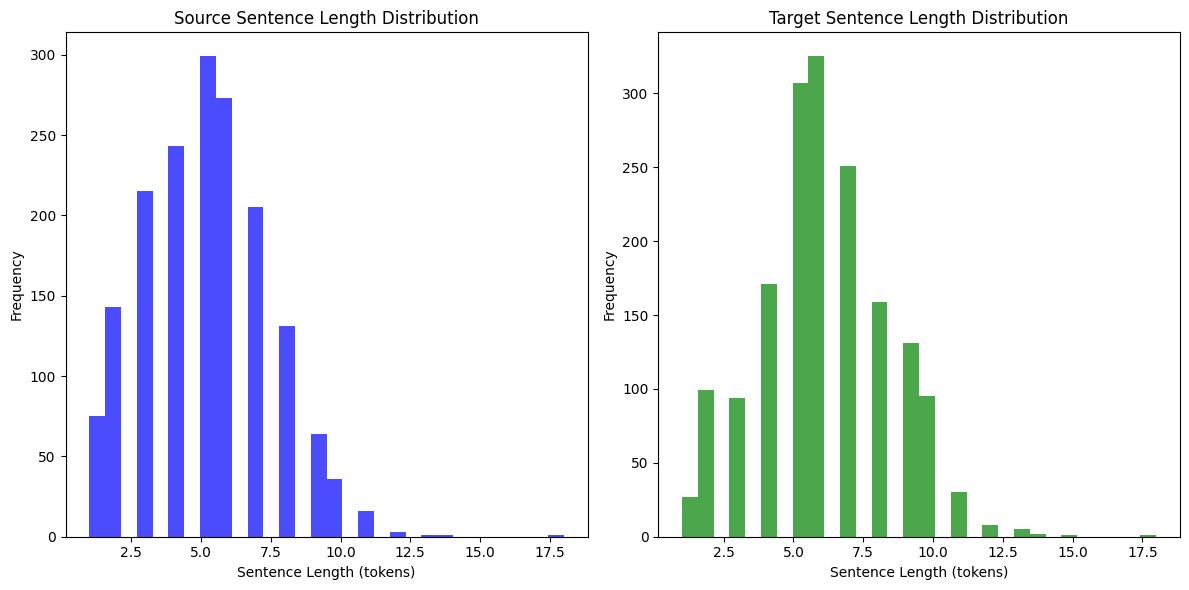

In [35]:
import matplotlib.pyplot as plt

# 각 문장의 토큰 길이를 KoBART 토크나이저로 계산 -> 서브워드 단어로 더 잘게 쪼개줌
df['source_len'] = df['gloss'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))
df['target_len'] = df['text'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))

# 히스토그램을 그려서 분포 확인
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df['source_len'], bins=30, color='blue', alpha=0.7)
plt.title('Source Sentence Length Distribution')
plt.xlabel('Sentence Length (tokens)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['target_len'], bins=30, color='green', alpha=0.7)
plt.title('Target Sentence Length Distribution')
plt.xlabel('Sentence Length (tokens)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [36]:
# 문장 길이 통계
source_stats = df['source_len'].describe(percentiles=[.25, .5, .75, .9, .95, .99])
target_stats = df['target_len'].describe(percentiles=[.25, .5, .75, .9, .95, .99])

print("Source Sentence Length Stats:\n", source_stats)
print("\nTarget Sentence Length Stats:\n", target_stats)

Source Sentence Length Stats:
 count    1706.000000
mean        5.150645
std         2.269818
min         1.000000
25%         3.000000
50%         5.000000
75%         7.000000
90%         8.000000
95%         9.000000
99%        11.000000
max        18.000000
Name: source_len, dtype: float64

Target Sentence Length Stats:
 count    1706.000000
mean        6.087925
std         2.336101
min         1.000000
25%         5.000000
50%         6.000000
75%         8.000000
90%         9.000000
95%        10.000000
99%        11.000000
max        18.000000
Name: target_len, dtype: float64


데이터셋의 문장 자체가 짧아서 짧게 지정하는데
- 메모리 효율성측면에서 max len이 너무 크면 메모리 낭비가 발생할 수 있어 작게 설정하는 것이 유리함



근데 평균적으로 이렇게 짧은 문장을 학습하지 않는걸까?
- 128 ~ 512 토큰: 일반적인 max_len 값으로, 대부분의 문장을 커버
- 1024 토큰: 더 긴 문장을 처리할 때 사용됩니다. GPT-2/3 같은 모델에서 긴 컨텍스트를 처리하기 위해 이 정도의 길이를 설정
- 2048 ~ 4096 토큰: 최근 큰 언어 모델(LLM)에서 더욱 긴 문맥을 처리하기 위해 사용되며, OpenAI의 GPT-4, Google's PaLM 등에서 이 정도 길이가 적용

## 2. 데이터 로더 생성

In [37]:
class GlossDataset(Dataset):
    def __init__(self, glosses, texts, tokenizer, max_len=10):
        self.glosses = glosses
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    # 데이터셋의 크기를 반환
    def __len__(self):
        return len(self.glosses)

    def __getitem__(self, idx):
        # 데이터 로드 및 전처리
        gloss = str(self.glosses[idx])
        text = str(self.texts[idx])

        # 토큰화
        inputs = self.tokenizer(
            gloss,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt" # 토큰화된 결과를 PyTorch 텐서로 반환
        )

        outputs = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        # 텐서 데이터 처리
        input_ids = inputs.input_ids.squeeze() # 1차원 처리해 gloss 토큰 id 텐서
        attention_mask = inputs.attention_mask.squeeze() # 마스킹 처리
        labels = outputs.input_ids.squeeze() # 1차원 처리해 text 토큰 id 텐서
        labels[labels == tokenizer.pad_token_id] = -100  # labels 텐서에서 패딩 토큰의 ID를 -100 변경 -> 학습 시 영향 안줌

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        } # 모델 학습에 사용될 데이터 로더에 의해 처리

In [38]:
from sklearn.model_selection import train_test_split

# 데이터셋 분할
train_glosses, val_glosses, train_texts, val_texts = train_test_split(df['gloss'].tolist(), df['text'].tolist(), test_size=0.2, random_state=42)
val_glosses, test_glosses, val_texts, test_texts = train_test_split(val_glosses, val_texts, test_size=0.5, random_state=42)

# 데이터셋 생성
train_dataset = GlossDataset(glosses=train_glosses, texts=train_texts, tokenizer=tokenizer)
val_dataset = GlossDataset(glosses=val_glosses, texts=val_texts, tokenizer=tokenizer)
test_dataset = GlossDataset(glosses=test_glosses, texts=test_texts, tokenizer=tokenizer)

# 데이터로더 생성
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
train_dataset[0]

{'input_ids': tensor([    0, 14245,  9618, 11696, 12037, 16212, 28379,     1,     3,     3]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0]),
 'labels': tensor([    0, 14245,  9618, 11696, 12037, 16212, 10338, 14039, 12258,     1])}

## 3. 모델 준비

In [40]:
import torch
from transformers import AdamW, get_linear_schedule_with_warmup

# 옵티마이저와 손실 함수 설정
optimizer = AdamW(model.parameters(), lr=2e-5)  # 학습률은 실험적으로 조정할 수 있음 1e-4, 1e-5
loss_fn = torch.nn.CrossEntropyLoss()

# 학습률 스케줄러 설정
num_epochs = 30

total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

## 4. KoBART 학습


In [41]:
# 체크포인트를 저장할 디렉토리 설정
import os

checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [42]:
model

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(30000, 768, padding_idx=3)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(30000, 768, padding_idx=3)
      (embed_positions): BartLearnedPositionalEmbedding(1028, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): Laye

In [43]:
# 손실 값을 저장할 리스트 초기화
train_losses = []
val_losses = []

# 조기 종료 변수 설정
early_stopping_patience = 3  # 손실 개선이 없을 때 기다리는 에포크 수
best_val_loss = float('inf')
epochs_since_improvement = 0

for epoch in range(num_epochs):
    model.train()  # 학습 모드로 전환
    total_loss = 0

    print(f'\nStarting epoch {epoch+1}/{num_epochs}')

    # tqdm을 사용하여 배치 진행 상태 표시
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
        optimizer.zero_grad()  # 기울기 초기화

        # 모델에 데이터 전달
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels'])
        loss = outputs.loss

        loss.backward()  # 역전파
        optimizer.step()  # 옵티마이저 스텝
        scheduler.step()  # 학습률 스케줄러 스텝

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)  # 훈련 손실 저장

    # Epoch 종료 후 검증 데이터셋에서 성능 평가
    model.eval()  # 평가 모드로 전환
    total_val_loss = 0
    with torch.no_grad():
        # tqdm을 사용하여 검증 배치 진행 상태 표시
        for batch in tqdm(val_dataloader, desc='Validation', unit='batch'):
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels'])
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)  # 검증 손실 저장

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}, Validation Loss: {avg_val_loss}')

    # 체크포인트 저장
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch32_{epoch+1}.pt')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': avg_loss,
        'val_loss': avg_val_loss,
    }, checkpoint_path)

    print(f'Checkpoint saved to {checkpoint_path}')

    # 조기 종료 확인
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_since_improvement = 0  # 손실 개선이 있으면 카운트 리셋
    else:
        epochs_since_improvement += 1
        if epochs_since_improvement >= early_stopping_patience:
            print(f"Early stopping triggered. No improvement for {early_stopping_patience} epochs.")
            break


Starting epoch 1/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.37batch/s]


Epoch 1/30, Loss: 3.318032688872759, Validation Loss: 1.7373992602030437
Checkpoint saved to ./checkpoints/checkpoint_epoch32_1.pt

Starting epoch 2/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.37batch/s]


Epoch 2/30, Loss: 1.725402177766312, Validation Loss: 1.323445479075114
Checkpoint saved to ./checkpoints/checkpoint_epoch32_2.pt

Starting epoch 3/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.65batch/s]


Epoch 3/30, Loss: 1.3602858518445216, Validation Loss: 1.1156491041183472
Checkpoint saved to ./checkpoints/checkpoint_epoch32_3.pt

Starting epoch 4/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.20batch/s]


Epoch 4/30, Loss: 1.0956617455149806, Validation Loss: 1.0071856776873271
Checkpoint saved to ./checkpoints/checkpoint_epoch32_4.pt

Starting epoch 5/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.81batch/s]


Epoch 5/30, Loss: 0.9256554675656695, Validation Loss: 0.9451700647672018
Checkpoint saved to ./checkpoints/checkpoint_epoch32_5.pt

Starting epoch 6/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.30batch/s]


Epoch 6/30, Loss: 0.784125495788663, Validation Loss: 0.9072757065296173
Checkpoint saved to ./checkpoints/checkpoint_epoch32_6.pt

Starting epoch 7/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  4.80batch/s]


Epoch 7/30, Loss: 0.6660144190455592, Validation Loss: 0.8953748345375061
Checkpoint saved to ./checkpoints/checkpoint_epoch32_7.pt

Starting epoch 8/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.28batch/s]


Epoch 8/30, Loss: 0.578912845877714, Validation Loss: 0.8871413667996725
Checkpoint saved to ./checkpoints/checkpoint_epoch32_8.pt

Starting epoch 9/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.28batch/s]


Epoch 9/30, Loss: 0.49757589850314826, Validation Loss: 0.895016094048818
Checkpoint saved to ./checkpoints/checkpoint_epoch32_9.pt

Starting epoch 10/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.23batch/s]


Epoch 10/30, Loss: 0.4488716250242189, Validation Loss: 0.8946073551972707
Checkpoint saved to ./checkpoints/checkpoint_epoch32_10.pt

Starting epoch 11/30


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.09batch/s]


Epoch 11/30, Loss: 0.38662442357041116, Validation Loss: 0.8930079539616903
Checkpoint saved to ./checkpoints/checkpoint_epoch32_11.pt
Early stopping triggered. No improvement for 3 epochs.


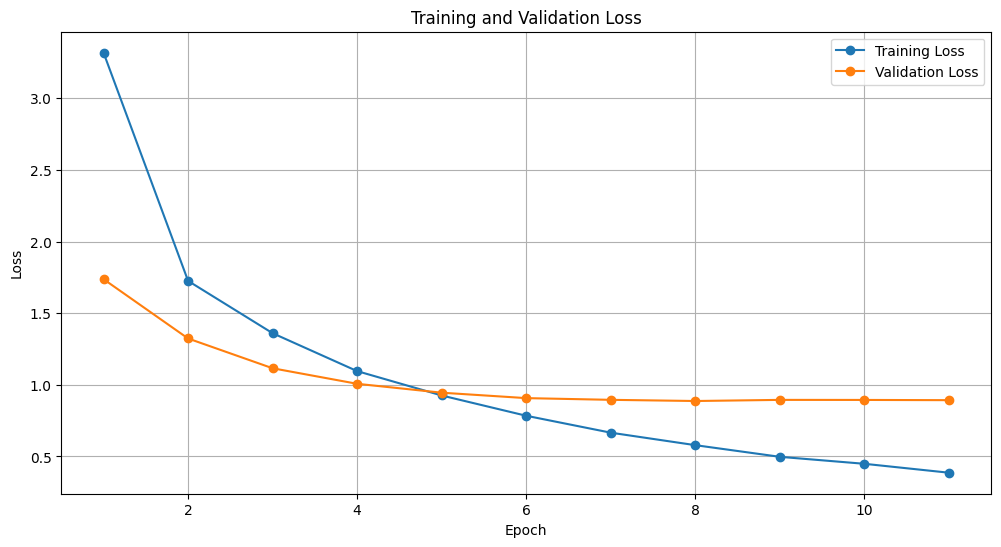

In [44]:
# 손실 값 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## 5. test

In [45]:
# 체크포인트 로드
checkpoint_path = './checkpoints/checkpoint_epoch_8.pt'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [46]:
model

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(30000, 768, padding_idx=3)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(30000, 768, padding_idx=3)
      (embed_positions): BartLearnedPositionalEmbedding(1028, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): Laye

In [24]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 853.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.7 MB/s eta 0:00:00


In [47]:
import sacrebleu

# 모델을 평가 모드로 설정
model.eval()

# 예측 및 참조 번역 수집
predictions = []
references = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        # 모델에 데이터 전달
        outputs = model.generate(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            max_length=256,  # 적절한 max_length 설정
            length_penalty=2.0,  # 번역 길이 조절
            num_beams=4,  # 빔 서치의 수
            early_stopping=True
        )

        # 예측 결과 디코딩
        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # 실제 레이블 디코딩
        decoded_labels = []
        for label in batch['labels']:
            # 패딩 토큰 ID 제외
            label_ids = label[label != tokenizer.pad_token_id].tolist()
            if label_ids:
                try:
                    decoded_label = tokenizer.decode(label_ids, skip_special_tokens=True)
                except OverflowError:
                    decoded_label = "[UNK]"  # Unknown token으로 처리
                decoded_labels.append(decoded_label)
            else:
                decoded_labels.append('')  # 빈 문자열로 처리

        # 예측 결과와 참조 번역 수집
        predictions.extend(decoded_preds)
        references.extend(decoded_labels)

# BLEU 점수 계산
bleu_score = sacrebleu.corpus_bleu(predictions, [references])
print(f'BLEU score: {bleu_score.score:.4f}')


Evaluating: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]

BLEU score: 9.4042


In [48]:
import torch

def generate_translation(model, tokenizer, sentences, max_length=50):
    model.eval()
    translations = []
    for sentence in sentences:
        # 토큰화 및 텐서 변환
        inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding='max_length', max_length=max_length)

        # GPU가 사용 중이면 데이터를 GPU로 이동
        input_ids = inputs['input_ids'].to(model.device)
        attention_mask = inputs['attention_mask'].to(model.device)

        # 모델에 데이터 전달
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            num_beams=5,  # Beam search 설정
            early_stopping=True
        )

        # 디코딩
        for output in output_ids:
            translation = tokenizer.decode(output, skip_special_tokens=True)
            translations.append(translation)

    return translations

# 테스트 문장
test_sentences = ["여름 덥다 화 난다", "목 마르다 물 부탁"]
translations = generate_translation(model, tokenizer, test_sentences)
print(translations)

['여름 더워서 화났어', '목 분실하였습니다.']
